[15844 36911 12932   697 18515]


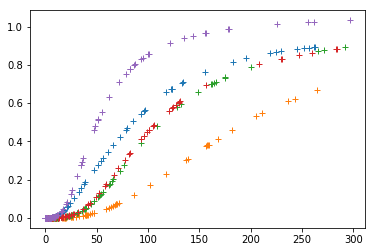

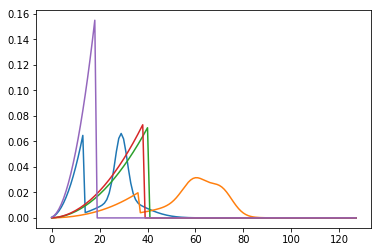

[33019  9445 43837 27799 54008]


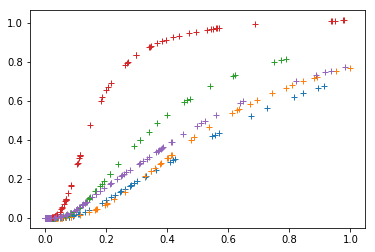

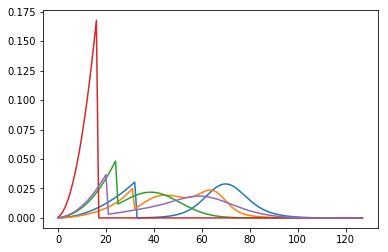

In [110]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import set_random_seed
from keras.callbacks import EarlyStopping

from keras.models import Sequential
# sequential model, for linear stack of NN layers

from keras.layers import Dense, Dropout, Activation, Flatten
# Dense is a standard densely connected NN layer
# Dropout randomly drops a percentage, p, of the neurons from a layer (helps reduce overfitting)

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# Convolution layers that help efficiently train image data

from keras.utils import np_utils
# used for transforming data

# read training and testing data
X_train = pd.read_pickle("../training_data/X_train.bz2").values
Y_train = pd.read_pickle("../training_data/Y_train.bz2").values
X_test = pd.read_pickle("../training_data/X_test.bz2").values
Y_test = pd.read_pickle("../training_data/Y_test.bz2").values

p = np.shape(X_train)[0] # number of training data
q = np.shape(X_test)[0] # number of test data

m = np.shape(X_train)[1]/2 # number of (T,cv) data
n = np.shape(Y_train)[1] # dimension of output vector

X_train = np.reshape(X_train, (p, 2, m, 1))
X_test = np.reshape(X_test, (q, 2, m, 1))

# check the loaded data
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X_train[i][0],X_train[i][1],'+')
    plt.figure(1)
    plt.plot(Y_train[i])

plt.show()

# preprocess input data

# cv lies in the range [0,1], whereas T is in the range [0.1,300]
# we should feature scale T by dividing by 300 (typical maximum value for real data)

X_train[:,0,:,0] /= 300.
X_test[:,0,:,0] /= 300.
# normalize so values range between 0 and 1

# check the processed data
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X_train[i][0],X_train[i][1],'+')
    plt.figure(1)
    plt.plot(Y_train[i])

In [2]:
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------
#
# REF: https://github.com/keras-team/keras/issues/7947

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [6]:
# set random seeds for repeatable behaviour
np.random.seed(140590)
set_random_seed(140590)

# here we define the model architecture
model = Sequential()

#input layer
model.add(Conv2D(32, (2, 2), input_shape=(2, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
print model.output_shape

model.add(MaxPooling2D(pool_size=(1,2)))
model.add(Dropout(0.25))
print model.output_shape

model.add(Flatten())
print model.output_shape

model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
print model.output_shape

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
print model.output_shape

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
print model.output_shape

model.add(Dense(n, activation='softmax'))
print model.output_shape

(None, 1, 127, 32)
(None, 1, 63, 32)
(None, 2016)
(None, 1024)
(None, 512)
(None, 256)
(None, 128)


In [7]:
# here we compile the model and define a loss function
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error', rmse, r_square])

In [8]:
# enabling early stopping based on mean_squared_error
earlystopping = EarlyStopping(monitor='mean_squared_error', patience=10, verbose=1, mode='auto')

In [ ]:
# now we can fit the model
result = model.fit(X_train, Y_train, batch_size=32, epochs=240, verbose=1, validation_data=(X_test, Y_test), callbacks=[earlystopping])

In [10]:
# get predictions
Y_pred = model.predict(X_test)

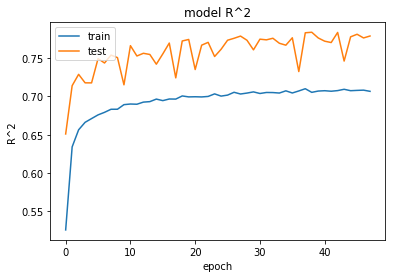

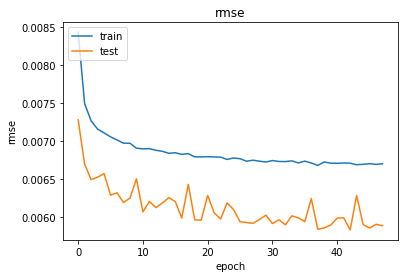

In [11]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
           
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [12]:
# print statistical figures of merit

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(Y_test,Y_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(Y_test,Y_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(Y_test,Y_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(Y_test,Y_pred))



Mean absolute error (MAE):      0.003013
Mean squared error (MSE):       0.000041
Root mean squared error (RMSE): 0.006368
R square (R^2):                 0.554132


1035


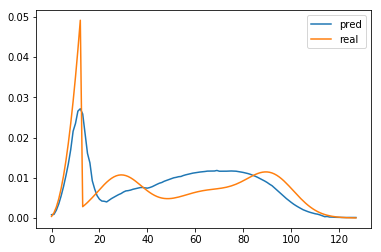

In [44]:
i = np.random.randint(0,q)
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.show()

7746


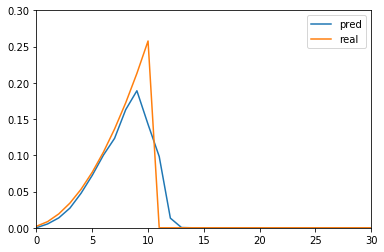

4160


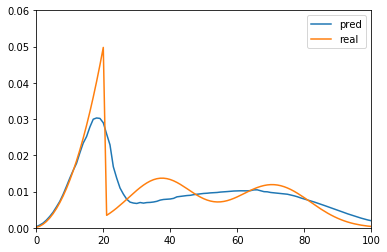

7606


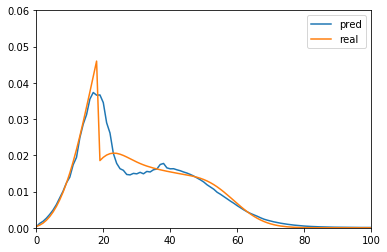

In [26]:
i = 7746
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,30,0,0.3])
plt.show()

i = 4160
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,100,0,0.06])
plt.show()

i = 7606
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,100,0,0.06])
plt.show()

In [27]:
# save model architecture, weights, training config, and state to HD5 file
model.save('./hc-CNN_004_NAdam_MSE_e048_b32.h5')

In [28]:
from keras.utils import plot_model
plot_model(model, to_file='model-CNN-004.png')

In [65]:
# compare the calculate cv with input cv

kB = 0.08617

def makeW(n):
    wmax = 120
    dw = wmax/(n*1.)
    return np.linspace(dw, wmax, n)

def kernel(w, T):
    y = np.outer(1/T/kB, w) # m x n matrix
    #return y
    return y*y*np.exp(-y)/(np.exp(-y)-1)**2

def cv(dos, T):
    return np.dot(kernel(w, T), dos)

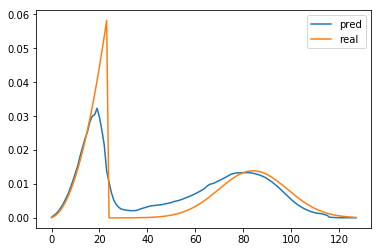

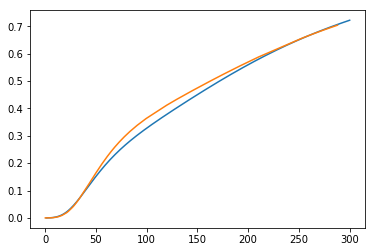

In [109]:
T = np.linspace(1,300,300)
w = makeW(128)
i=50
plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.show()
plt.plot(T,cv(Y_pred[i],T))
dat = X_test[i].reshape((2,128))
plt.plot(dat[0]*300,dat[1])